# Lab / M2-DS / Audio and Music Information Retrieval / Automatic Chord Recognition (ACR)

- Author: geoffroy.peeters@telecom-paris.fr
- Date: 2021/02/11
- Version: 1.0

Student: Adame Ben Friha

## Introduction

The goal of this goal is to create an Automatic Chord Recognition (ACR) system from scratch.
To do so you will 
- 1) compute the Chromagram (temporal sequence of chroma) presentation of an audio signal
- 2) implement a simple hidden Markov model (HMM) which states are the chords to be recognized
- 3) decode the most likely succession of chord-states of the HMM given the observed sequence of chroma)

To do so, we will use the following flowchart which is made up of a set of functions; each perform a specific task:
- ```F_get_stft``` compute the Short-Time-Fourier-Transform (STFT) of an audio signal. 
- ```F_get_chromagram``` transform the STFT into a spectrogram using the conversion-filters given by ```F_get_notechroma_filtre```.
- ```F_compute_obs``` compute the observation/emission probability of the HMM given the chromagram and the chord-templates given by ```F_create_chord_templates```
- ```F_viterb_decoding``` performs the Viterbi decoding of the chord sequence of the HMM given the transition probability given by ```F_compute_ptrans```.

<img src=https://perso.telecom-paristech.fr/gpeeters/doc/M2DS_-AMIR-LabChordRecognition-20202021_figure//lab_chord_flowchart.png width=800px>

## Your task:

In the following the main code (global architecture) is provided as well as the results you have to find.
YOur task is to fill in the missing parts in the code; i.e. the parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```).

## Notes:

For clarity and easiness-of-understanding of the code, we will use the following coding rules:

**Data type**
- a variable ending with ```_d```denotes a python dictionary
- a variable ending with ```_l```denotes a python list
- a variable ending with ```_dl```denotes a python list of python dictionary
- a variable ending with ```_v```denotes a numpy 1D-array or a vector
- a variable ending with ```_m```denotes a numpy 2D-array or a matrix

**Data unit**
- units in which the data are expressed using ```_hz``` for data in Hz, ```_sec``` in seconds, ```_n```in samples.

**Other**
- user defined functions start with a ```F_```


# Import packages

In [ ]:
! pip install librosa

In [213]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb
import json
import pprint as pp

import librosa
eps = 1e-10
my_cmap = plt.cm.get_cmap('gray').reversed()

#audio_file = './gammepno.wav'
audio_file = './Isophonics_01_-_Help!.mp3'

do_student = True

### Load audio file

In [214]:
audio_v, sr_hz = librosa.load(audio_file)

/tmp/ipykernel_145383/2503967470.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_v, sr_hz = librosa.load(audio_file)


# Compute STFT

We first compute the amplitude Short Time Fourier Transform: $|X(k,n)|$.

We do this using an analysis window of duration ```L_sec``` and of type hamming (```np.hamming```). 
We choose the hope-size (i.e. the distance between two successive frames) as 1/3 of the window length.

To increase the spectral precision (i.e. the distance in Hz between two adjacent DFT frequencies $f_k$ and $f_{k-1}$), we will a large **zero-padding**, i.e. we choose the size ```N``` of the DFT as ```8*nextpow2()``` the size in samples of the window in samples ```L_n```.

For this function, we need to perform successively the following step: convert the window size in samples, compute the analysis window, compute the value of ```N```, get the total number of frames that fit in the signal length, allocate matrix that will store the STFT, loop over the frames. 

The DFT can be computed using ```np.fft.rfft```.

In [4]:
def F_nextpow2(i):
    """
    Find 2^n that is equal to or greater than.
    """
    N = 1
    while N < i:
        N *= 2
    return N

In [237]:
def F_get_stft(audio_v, sr_hz, L_sec):
    """
    description:
        compute the amplitude of the short-time-fourier-transform using a given window duration L_sec
    inputs:
        audio_v: audio signal data
        sr_hz: sampling rate of audio signal [in Hz]
        L_sec: duration of the analysis window [in second]
    outputs:
        am_fft_m (N/2+1, nb_frame): numpy matrix which stores the amplitude of the STFT 
            (because of symetry we only keep the positive axis, hence N/2+1)
        freq_hz_v (N/2+1): numpy vector which stores the frequencies of the DFT [in Hz]
        time_sec_v (nb_frame): numpy vector which stores the middle-time positions of the STFT frames [in second]
    """
    
    if do_student:
        # --- START CODE HERE
        # Initialise useful variables
        L_n = int(L_sec * sr_hz)
        LT_n = audio_v.shape[0]
        hop_sec = L_sec / 3
        hop_n = int(hop_sec * sr_hz) # Hop size
        nb_frame = 1 + (LT_n - L_n) // hop_n
        N = 8 * F_nextpow2(L_n)
        
        # Initialise output matrices/lists with zeros
        am_fft_m = np.zeros((N // 2 + 1, nb_frame))
        freq_hz_v = np.arange(0, 1 + N / 2) * sr_hz * 2 / N
        time_sec_v = np.linspace(L_sec / 2, L_sec / 2 + nb_frame * hop_sec, num=nb_frame, endpoint=True)
        
        # Compute the three desired outputs
        for num_frame in range(nb_frame):
            excerpt = audio_v[num_frame * hop_n:num_frame * hop_n + L_n]
            excerpt_analysed = excerpt * np.hamming(L_n)
            dft_output = np.fft.rfft(excerpt_analysed, N)
            am_fft_m[:,num_frame] = np.abs(dft_output)
        # --- END CODE HERE
        
        
    return am_fft_m, freq_hz_v, time_sec_v

## Test

We now test the ```F_get_stft```function. 

For the audio signal ```gammepno.wav```, you should obtain the following numbers and figure.

<img src=https://perso.telecom-paristech.fr/gpeeters/doc/M2DS_-AMIR-LabChordRecognition-20202021_figure//lab_chord_stft.png width=800px>

(32769, 1410)
(32769,)
(1410,)


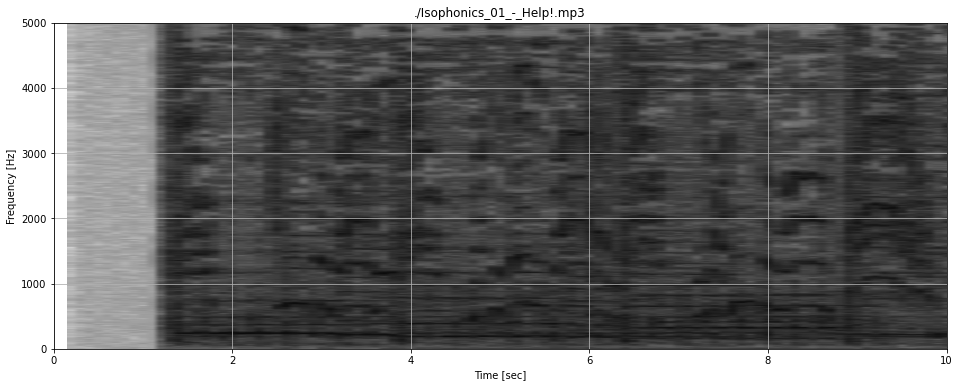

In [238]:
am_fft_m, freq_hz_v, time_sec_v = F_get_stft(audio_v, sr_hz, L_sec=0.3)
print( am_fft_m.shape )
print( freq_hz_v.shape )
print( time_sec_v.shape )

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.imshow( np.log(1+1e6*am_fft_m), aspect='auto', origin='lower', cmap=my_cmap, extent=(time_sec_v[0], time_sec_v[-1], freq_hz_v[0], freq_hz_v[-1]))
ax.set_xlabel('Time [sec]'), ax.set_ylabel('Frequency [Hz]')
ax.set_xlim((0, 10))
ax.set_ylim((0, 5e3))
ax.set_title(audio_file)
plt.grid(True)

# Compute Chromagram from STFT

We now convert the STFT to a Chromagram. The Chromagram has the same time dimension has the STFT (number of frames) but it maps the frequencies $f_k$ of the STFT to the 12 chroma-values (C,C#,D,...).
We do this in two steps.

- 1) ```F_get_notechroma_filtre```: we first create a conversion-matrix that will map the SFTF frequencies $f_k$ to the 12 chroma-values. 
- 2) ```F_get_chromagram```: we mulitply the STFT matrix by the conversion-matrix.


## Compute Note and Chroma filters

To compute the chroma filters, we 
- first create the set of note-filters, i.e. the set of filters centered around each midi-pitch
- then, for a given chroma, we add all the note-filters that correspond to the same chroma.

For the shape of the filter, we will use a simple triangular shape with maximum-value of 1 on the midi-note, 0.5 between two midi-notes and 0 on the previous and next midi note.

To create the filters, 
- we consider all the midi-notes between ```midi_min``` and ```midi_max```
- to create the note-filters, we convert the STFT frequencies $f_k$ (```freq_hz_v```) to a midi-scale (using ```F_hz2midi```) and compute the triangular shape  

In [218]:
def F_hz2midi(freq, tuning_hz=440): 
    """
    convert frequency in Hz to midi value (440Hz -> midi=69)
    """
    
    return 12*np.log2((freq+eps)/tuning_hz) + 69


def F_midi2hz(midi, tuning_hz=440): 
    """
    convert midi value to Hz (midi=69 -> 440Hz)
    """
    
    return tuning_hz * (2**((midi - 69)/12))

In [219]:
def F_get_notechroma_filtre(freq_hz_v, tuning_hz=440):
    """
    description:
        compute the note-filters and chroma-filters
    inputs:
        freq_hz_v (N/2+1): numpy vector which stores the frequencies of the DFT [in Hz]
        tuning_hz: optimal tuning (default is 440 Hz)
    outputs:
        chroma_filtre_m (N/2+1, 12): numpy matrix which stores the 12 filters to map the DFT frequencies to chroma
        note_filtre_m (N/2+1, nb_midi_note): numpy matrix which stores the nb_midi_note filters to map the DFT frequencies to midi_note
        midi_v (nb_midi_note): numpy vector which stores the value of the midi notes
    """
    
    midi_min = np.round(F_hz2midi(100, tuning_hz=tuning_hz))
    midi_max = np.round(F_hz2midi(4000, tuning_hz=tuning_hz))
    
    if do_student:
        # --- START CODE HERE
        nb_freqs = freq_hz_v.shape[0]
        nb_midi_note = int(midi_max - midi_min)
        note_filtre_m = np.zeros((nb_freqs, nb_midi_note))
        chroma_filtre_m = np.zeros((nb_freqs, 12))
        
        for midi_note in range(int(midi_min), int(midi_max)):
            # Get the associated frequency, as well as the frequencies associated with neighbouring notes
            current_freq = F_midi2hz(midi_note)
            previous_freq = F_midi2hz(midi_note - 1)
            next_freq = F_midi2hz(midi_note + 1)
            
            # Create the filter for the current note
            note_filter = np.zeros(nb_freqs)
            for i in range(nb_freqs):
                if freq_hz_v[i] == current_freq:
                    note_filter[i] = 1.
                elif freq_hz_v[i] > previous_freq and freq_hz_v[i] < current_freq:
                    note_filter[i] = (freq_hz_v[i] - previous_freq) / (current_freq - previous_freq)
                elif freq_hz_v[i] < next_freq and freq_hz_v[i] > current_freq:
                    note_filter[i] = (next_freq - freq_hz_v[i]) / (next_freq - current_freq)
            
            # Normalise the filter (with what constant?)
            note_filter /= np.linalg.norm(note_filter, ord=1)
            note_filtre_m[:,int(midi_note - midi_min)] = note_filter
            
            chroma_filtre_m[:,int(midi_note) % 12] += note_filter
        
        midi_v = np.arange(midi_min, midi_max)
        # --- END CODE HERE
        
    return chroma_filtre_m, note_filtre_m, midi_v

### Test

We now test the ```F_get_notechroma_filtre```function. 

For the audio signal ```gammepno.wav```, you should obtain the following numbers and figure.


<img src=https://perso.telecom-paristech.fr/gpeeters/doc/M2DS_-AMIR-LabChordRecognition-20202021_figure//lab_chord_chroma_filtre.png width=800px>

(32769, 12)
(32769, 64)
(64,)


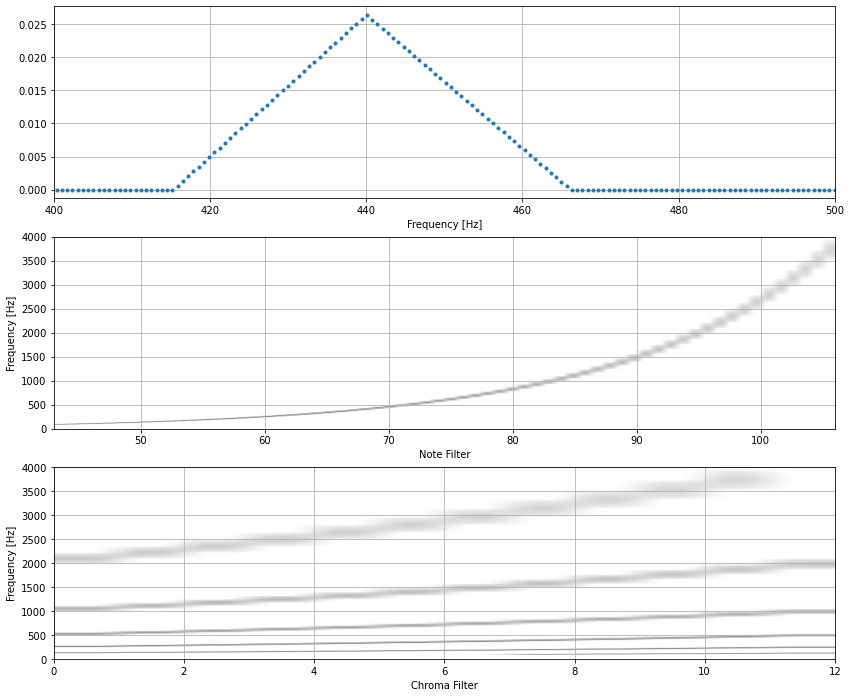

In [220]:
chroma_filtre_m, note_filtre_m, midi_v = F_get_notechroma_filtre(freq_hz_v)
print( chroma_filtre_m.shape )
print( note_filtre_m.shape )
print( midi_v.shape )

fig, ax = plt.subplots(3, 1, figsize=(14, 12))

ax[0].plot(freq_hz_v, note_filtre_m[:, np.where(midi_v==69)[0]], '.')
ax[0].set_xlabel('Frequency [Hz]'); ax[0].set_xlim((400,500)); 
ax[0].grid(True)

ax[1].imshow(np.sqrt(note_filtre_m), aspect='auto', origin='lower', cmap=my_cmap, extent=(midi_v[0], midi_v[-1], freq_hz_v[0], freq_hz_v[-1]))
ax[1].set_xlabel('Note Filter');
ax[1].set_ylabel('Frequency [Hz]'); ax[1].set_ylim((0,4000))
ax[1].grid(True)

ax[2].imshow(np.sqrt(chroma_filtre_m), aspect='auto', origin='lower', cmap=my_cmap, extent=(0, 12, freq_hz_v[0], freq_hz_v[-1]))
ax[2].set_xlabel('Chroma Filter');
ax[2].set_ylabel('Frequency [Hz]'); ax[2].set_ylim((0,4000))
ax[2].grid(True)

## Convert STFT to Chromagram using the Chroma filters

To convert the STFT ```am_fft_m``` to a Chromagram ```chromagram_m```, we simply multiply the STFT matrix by the conversion-matrix ```chroma_filtre_m``` we just created.

In [239]:
def F_get_chromagram(am_fft_m, chroma_filtre_m):
    """
    description:
        compute the chromagram representation givin the STFT and the chroma filter
    inputs:
        am_fft_m (N/2+1, nb_frame): numpy matrix which stores the amplitude of the STFT 
        chroma_filtre_m (N/2+1, 12): numpy matrix which stores the 12 filters to map the DFT frequencies to chroma
    outputs:
        chromagram_m (12, nb_frame): numpy matrix which stores the 12 chroma-values for each time frame
    """

    if do_student:
        # --- START CODE HERE 
        chromagram_m = np.dot(chroma_filtre_m.T, am_fft_m)
        # --- END CODE HERE

    return chromagram_m

### Test

We now test the ```F_get_chromagram```function. 

For the audio signal ```gammepno.wav```, you should obtain the following numbers and figure.


<img src=https://perso.telecom-paristech.fr/gpeeters/doc/M2DS_-AMIR-LabChordRecognition-20202021_figure//lab_chord_chromagram.png width=800px>

(12, 1410)


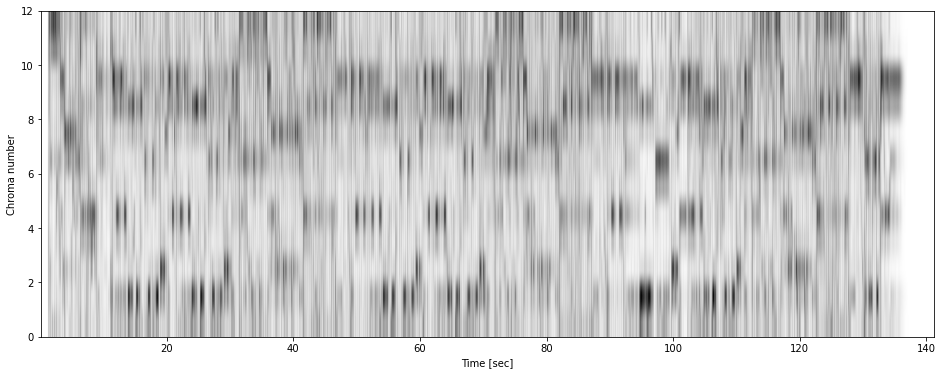

In [240]:
chromagram_m = F_get_chromagram(am_fft_m, chroma_filtre_m)
print( chromagram_m.shape )

plt.figure(figsize=(16, 6))
plt.imshow( chromagram_m, aspect='auto', origin='lower', cmap=my_cmap, extent=(time_sec_v[0], time_sec_v[-1], 0, 12));
plt.xlabel('Time [sec]'); plt.ylabel('Chroma number');

# Chord estimation from Chromagram using Hidden Markov Model

Given our observations $O_t$ (stored in ```chromagram_m```), we now estimate the chord sequence by decoding (using the Viterbi decoding algorithm) the most-likely succession of states $q_t$ from a Hidden Markov Model (HMM).

For this, we first create the HMM.

We define the states $S_j$ of the HMM as the 24 possible Major and minor scales, i.e. a Major and a minor chord starting from each of the possible root note C, C#, D, D#, ...

To estimate the observation/emission probability $p(O_t|q=S_j)$, we will use a simple template-based method, i.e. we will compare the theoretical chord-pattern of chord $S_j$ to the observed chroma $O_t$. We will do so by simply computing the dot-product between $O_t$ and the chord-pattern of chord $S_j$. 
At each time $t$, we then normalize over all $j$ to get a probability.

## Emission probability

We first start by creating the chord-templates $T_j$ for each possible Major and minor chords. 
Each chord-template has 12-dimensions (the same as the chroma representation).

We first define a prototype chord-templates for Major chords $T_M$ and minor chords $T_m$ by defining the values at which the template should be equal to 1: it is defined as ```[0,4,7]```for Major chords and ```[0,3,7]```for minor chords. 
This correspong to the root-note (```0```), major or minor third interval (```4``` or ```3```) and fifth interval (```7```).

Using these prototypes, we then create the chord-templates $T_j$ for the 12 possible root-note (C, C#, D, D#, ...). 
We simply do this by circular permutation of prototype-chord-template.

We thus have 2 (Major, minor) * 12 (C, C#, D, D#, ...) = 24 chord-templates.

We also add a non-chord (```N```) which is an empty chord-pattern. 
The goal of the later is to allow easy comparison with ground-truth annotated data which contains the ```N```chord-label.

**Advanced students**: you can test adding new prototype chords such as maj7, dom7, min7: ```[0,4,7,11]```, ```[0,4,7,10]```, ```[0,3,7,10]```.

### Compute chord templates

In [241]:
def F_create_chord_templates():
    """
    description:
         compute chord templates for each chord type (major, minor)
    inputs:
    
    outputs:
        chord_template_m (nb_chord, 12): numpy matrix which stores the theoretical value of the 12-chromas for each chord
        chord_name_l (nb_chord): list of chord names
        root_name_l (12): list of root-note names
    """
    
    chordtype_d = {}
    chordtype_d[''] = [0,4,7] # --- major
    chordtype_d[':min'] = [0,3,7] # --- minor
    root_name_l = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
        
    if do_student:
        # --- START CODE HERE
        # First determine the chord names
        chord_name_l = root_name_l + [root_name + ':min' for root_name in root_name_l]
        chord_name_l.append('N')
        
        nb_chord = len(chord_name_l)
        
        # Then build the chord template matrix
        chord_template_m = np.zeros((nb_chord, 12))
        
        for i in range(12):
            major_chord_template = [(k-i)%12 in(chordtype_d['']) for k in range(12)]
            minor_chord_template = [(k-i)%12 in(chordtype_d[':min']) for k in range(12)]
            
            chord_template_m[i] = major_chord_template
            chord_template_m[i+12] = minor_chord_template
        # --- END CODE HERE
     
    return chord_template_m, chord_name_l, root_name_l

### Test

We now test the ```F_create_chord_templates```function. 

You should obtain the following numbers and figure.

<img src=https://perso.telecom-paristech.fr/gpeeters/doc/M2DS_-AMIR-LabChordRecognition-20202021_figure//lab_chord_templates.png width=800px>

(25, 12)
25
12


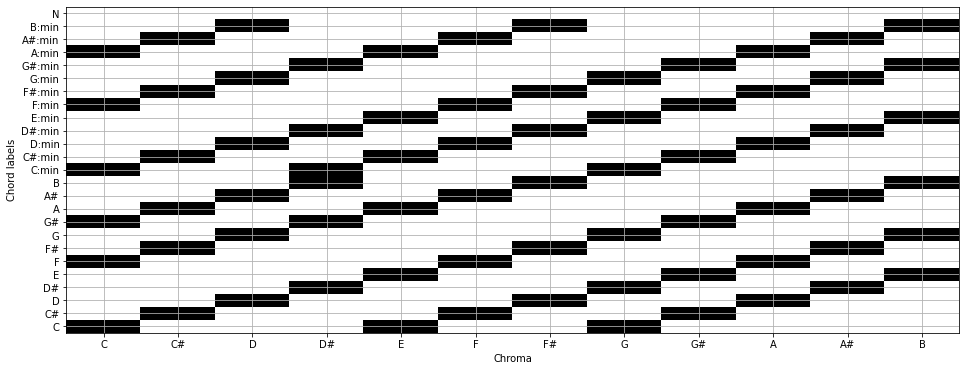

In [242]:
chord_template_m, chord_name_l, root_name_l = F_create_chord_templates()
print( chord_template_m.shape )
print( len(chord_name_l) )
print( len(root_name_l) )

# ------------------------------------------
plt.figure(figsize=(16, 6))
plt.imshow(chord_template_m, aspect='auto', origin='lower', cmap=my_cmap)
plt.grid(True)
plt.xlabel('Chroma'); plt.xticks(np.arange(0,12), root_name_l);
plt.ylabel('Chord labels'); plt.yticks(np.arange(0,len(chord_name_l)), chord_name_l);

### Compute emission/observation probability as product between chroma and template

Using our observations $O_t$ (stored in ```chromagram_m```) and the chord-templates $T_j$ (stored in ```chord_template_m```), we compute the observation/emission probability $p(O_t|q=S_j)$ by simply computing the dot product between $O_t$ and the chord-pattern $T_j$. 
We then normalize over all $j$ to get a probability.

In [226]:
def F_compute_pobs(chromagram_m, chord_template_m):
    """
    description:
        compute the emission probability of each chord at each time
        method: using the dot product between chroma and template
        warning: since it is a probability it should be normalized to 1 at each frame
    inputs:
        chromagram_m (12, nb_frame): numpy matrix which stores the 12 chroma-values for each time frame
        chord_template_m (nb_chord, 12): numpy matrix which stores the theoretical value of the 12-chromas for each chord
    outputs:
        pobs_m (nb_chord, nb_frame): numpy matrix which stores the emission/observation probability of each chord at each time frame
    """
    
    if do_student:
        # --- START CODE HERE 
        pobs_m = chord_template_m @ chromagram_m
        # Then, normalise the result
        norms = np.linalg.norm(pobs_m, axis = 0, keepdims=True)
        pobs_m /= norms
        # --- END CODE HERE

    return pobs_m

### Test

We now test the ```F_compute_pobs```function. 

For the audio signal ```gammepno.wav```, you should obtain the following numbers and figure.

<img src=https://perso.telecom-paristech.fr/gpeeters/doc/M2DS_-AMIR-LabChordRecognition-20202021_figure//lab_chord_pobs.png width=800px>

(25, 1410)


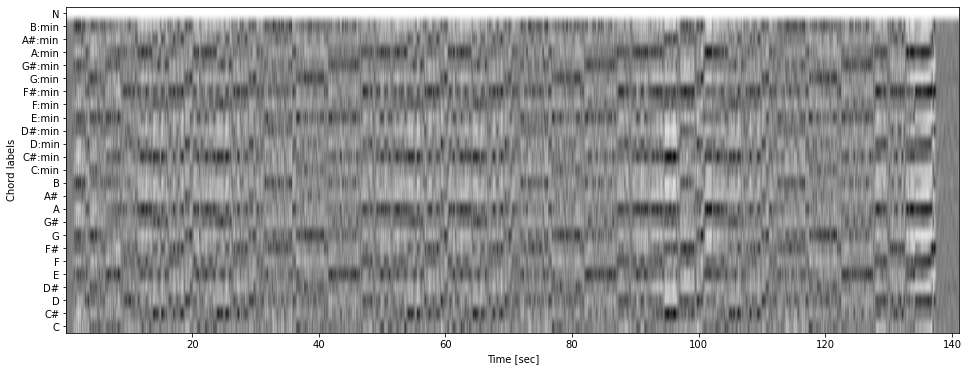

In [243]:
pobs_m = F_compute_pobs(chromagram_m, chord_template_m)
print( pobs_m.shape )

plt.figure(figsize=(16, 6))
plt.imshow(pobs_m, aspect='auto', origin='lower', cmap=my_cmap, extent=(time_sec_v[0], time_sec_v[-1], 0, len(chord_name_l)));
plt.xlabel('Time [sec]'); 
plt.ylabel('Chord labels'); plt.yticks(np.arange(0,len(chord_name_l))+0.5, chord_name_l);

## Transition matrix

So far, there is nothing of a Hidden Markov Model because we still need to define some transition probability $a_{ij} = P(q_{t}=S_j | q_{t-1}=S_i)$, i.e. the probability to transit from a chord $i$ at time $(t-1)$ to a chord $j$ at time $t$.

There are many ways to define the transition probabilities between chords (see Lecture 1).

To define **how likely it is to have a chord $j$ after a chord $i$**, we use the similarity between chords $i$ and $j$.
This similarity is computed by the dot-product between their respective chord-templates $T_i$ and $T_j$.

Note that this is equivalent to the use of the distance between the chords in the **Tonnetz-space** representation (see Lecture 1).

**Normalization:** We of course need to normalize this value to make a probability: $\sum_j a_{ij} = 1$.

**Trick:** to improve the transition-matrix and reduce the probabiliy of transiting from $i$ to $j \neq i$, we will exponent $a_{ij}$ by ```**3``` before normalization. 
This will increase the probability of self-transition and thus reduce the number of state-skip or fragmentation.

In [278]:
def F_compute_ptrans(chord_template_m):
    """
    description:
        compute the transition probability p(q_{t+1}=S_j | q_{t}=S_i) stored as a matrix a_{ij}
        method: we use the dot product between chord templates i and j
        warning: since it is a probability it should be normalized over j for each i
    inputs:
        chord_template_m (nb_chord, 12): numpy matrix which stores the theoretical value of the 12-chromas for each chord
    outputs:
        ptrans_m (nb_chord, nb_chord): numpy matrix which stores the transition probability a_{ij} between chords
    """
   
    if do_student:
        # --- START CODE HERE 
        nb_chord = chord_template_m.shape[0]
        ptrans_m = np.zeros((nb_chord, nb_chord))
        for i in range(nb_chord - 1):
            for j in range(nb_chord - 1):
                ptrans_m[i, j] = chord_template_m[i].T @ chord_template_m[j]
            ptrans_m[i,:] **= 3
            ptrans_m[i,:] /= np.linalg.norm(ptrans_m[i,:], ord=1)
        # --- END CODE HERE

    return ptrans_m

### Test

We now test the ```F_create_chord_templates```function. 

You should obtain the following numbers and figure.

<img src=https://perso.telecom-paristech.fr/gpeeters/doc/M2DS_-AMIR-LabChordRecognition-20202021_figure//lab_chord_ptrans.png width=800px>

(25, 25)


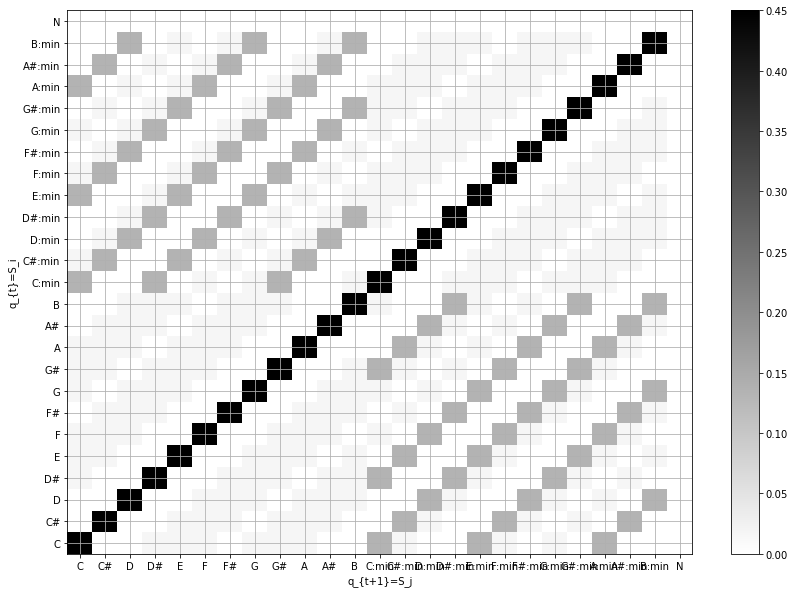

In [279]:
ptrans_m = F_compute_ptrans(chord_template_m)
#ptrans2_m = F_compute_ptrans_circle_of_fifth(chord_name_l)

print( ptrans_m.shape )
plt.figure(figsize=(14, 10));
plt.imshow(ptrans_m, aspect='auto', origin='lower', cmap=my_cmap);
plt.grid(True);
plt.xticks(np.arange(0,len(chord_name_l)), chord_name_l); plt.xlabel('q_{t+1}=S_j');
plt.yticks(np.arange(0,len(chord_name_l)), chord_name_l); plt.ylabel('q_{t}=S_i');
plt.colorbar();

## Viterbi decoding algorithm

Given the prior probability (```prior_v```), the observation/emission probability (```pobs_m```) and the transition probability (```ptrans_m```), we now use the Viterbi decoding algorithm to find the most likely path (```q_v```) over the chord-states.

We do this by first performing the ```forward-pass``` using the $\delta_t(i)$ variable, selecting the highest $q^*_T = \arg\max_i \delta_T(i)$ at the final time and then performing the ```backward-pass``` from its corresponding $\psi_T(q^*_T)$.

**See slides of Lecture 1 (slide 116) for details.**

To implement this (and avoid numerical errors), it is highly recommended that you use ```log-probabilities``` instead of probabilities:

$$\delta_1(i) = \pi_i B_1(X_1) \Longrightarrow log(\delta_1(i)) = log(\pi_i) + \log(B_1(X_1))$$

This will not change the ranking, hence 

$$\max_i ( \delta_{t-1}(i) \; a_{ij} ) = \max_i ( \log(\delta_{t-1}(i)) + \log(a_{ij}) )$$

In [283]:
def F_viterbi_decoding(prior_v, pobs_m, ptrans_m):
    """
    description:
        get the most likely path q_v other time using the Viterbi decoding algorithm
    inputs:
        prior_v (nb_chord): numpy vector which stores the prior probability of each chord
        pobs_m (nb_chord, nb_frame): numpy matrix which stores the emission/observation probability of each chord at each time frame
        ptrans_m (nb_chord, nb_chord): numpy matrix which stores the transition probability a_{ij} between chords
    outpus:
        q_v (nb_frame): numpy vector which stores the most likely temporal path over chords
    """
    
    if do_student:
        # --- START CODE HERE 
        nb_frame = len(pobs_m[0])
        nb_chord = len(prior_v)
        q_v = np.zeros(nb_frame)
        
        # Forward pass of the Viterbi algorithm
        log_delta_m = np.zeros((nb_chord, nb_frame))
        psi_m = np.zeros((nb_chord, nb_frame))
        eps = 1e-15
        # -- Initialisation
        log_delta_m[:, 0] = np.log(pobs_m[:, 0] + eps) + np.log(prior_v + eps)
        # -- Recursion
        for t in range(1, nb_frame):
            for j in range(nb_chord):
                row_to_consider = log_delta_m[:, t-1] + np.log(ptrans_m[:, j] + eps)
                log_delta_m[j, t] = max(row_to_consider) + np.log(pobs_m[j, t] + eps)
                psi_m[j, t] = np.argmax(row_to_consider)
        # -- Termination
        q_v[-1] = np.argmax(log_delta_m[:, nb_frame - 1])
        # Backward pass
        for t in range(nb_frame - 2, -1, -1):
            q_v[t] = psi_m[int(q_v[t+1]), t+1]
        # --- END CODE HERE
        
    return q_v

### Test

We now test the ```F_viterbi_decoding```function. 

For this, we now switch to the music track "Help !" from The Beatles.
<img src=https://perso.telecom-paristech.fr/gpeeters/doc/M2DS_-AMIR-LabChordRecognition-20202021_figure//chord_help.jpg width=200px>

Its audio signal is in the file ```Isophonics_01_-_Help!.mp3```.

In the following figure (you should obtain the same), we compare 
- in green: the frame-based approach (which takes the most likely chord at each frame individually $\arg \max_j $p(O_t|q=S_j)$).
- in red: the viterbi decoding chord sequence ```q_v``` (which uses the transition probability) to 

Those roughly correspond to the frame-based approach of ```[Fujishima, 1999]``` and the HMM-based approach of  ```[Papadopoulos, Peeters, 2017]``` and the   we saw in Lecture 1.

As you can see in the Figure, the chord sequence obtained with the HMM (red) is much better (much less fragemented) than the one obtained with a frame-based decision (red).

<img src=https://perso.telecom-paristech.fr/gpeeters/doc/M2DS_-AMIR-LabChordRecognition-20202021_figure//lab_chord_decoding.png width=800px>


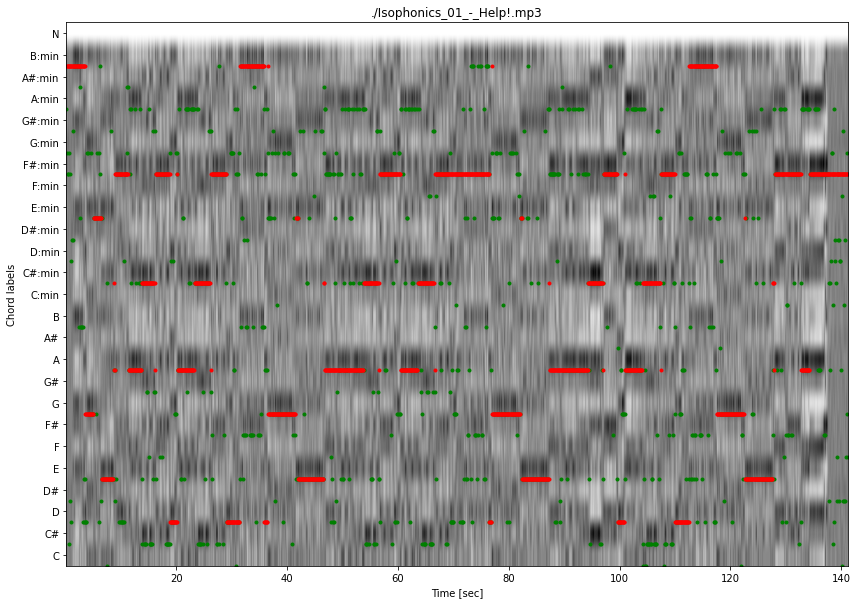

In [284]:
# --- HMM-based approach
# --- define a uniform prior probability
nb_chord = len(chord_name_l)
prior_v = np.ones(nb_chord) / nb_chord
viterbi_path_v = F_viterbi_decoding(prior_v, pobs_m, ptrans_m)

# --- Frame-based approach
argmax_path_v = np.argmax(pobs_m, axis=0)


plt.figure(figsize=(14, 10));
plt.imshow(pobs_m, aspect='auto', origin='lower', cmap=my_cmap, extent=(time_sec_v[0], time_sec_v[-1], 0, len(chord_name_l)));
plt.plot(time_sec_v, argmax_path_v, 'g.')
plt.plot(time_sec_v, viterbi_path_v, 'r.')
plt.xlabel('Time [sec]'); 
plt.ylabel('Chord labels'); 
plt.yticks(np.arange(0,len(chord_name_l))+0.5, chord_name_l);
plt.title(audio_file);

# Evaluation of the performance

We will now measure the performance  of our system by comparing its performances to the ground-truth chord annotation ```[given by the Isophonics dataset, Queen Mary University of London]```.

We first load the annotations and check that the ```chord-dictionary``` of the annotations correspond to the one of our system, if not, we simply map the chord.

In [285]:
annotation_filename = './Isophonics_01_-_Help!.jams'

with open(annotation_filename) as fid: annot_d = json.load(fid)
chord_annot_dl = annot_d['annotations'][0]['data']

# --- Replace annotated-chord-labels which are outside our system-chord-vocabulary
for chord_annot_d in chord_annot_dl:
    chord_annot_d['value'] = chord_annot_d['value'].replace(':maj6','')

set([chord_annot_d['value'] for chord_annot_d in chord_annot_dl])

{'A', 'B:min', 'C#:min', 'D', 'E', 'F#:min', 'G', 'N'}

We then visually compare our systems prediction to the ground-truth.

<img src=https://perso.telecom-paristech.fr/gpeeters/doc/M2DS_-AMIR-LabChordRecognition-20202021_figure//lab_chord_groundtruth.png width=800px>

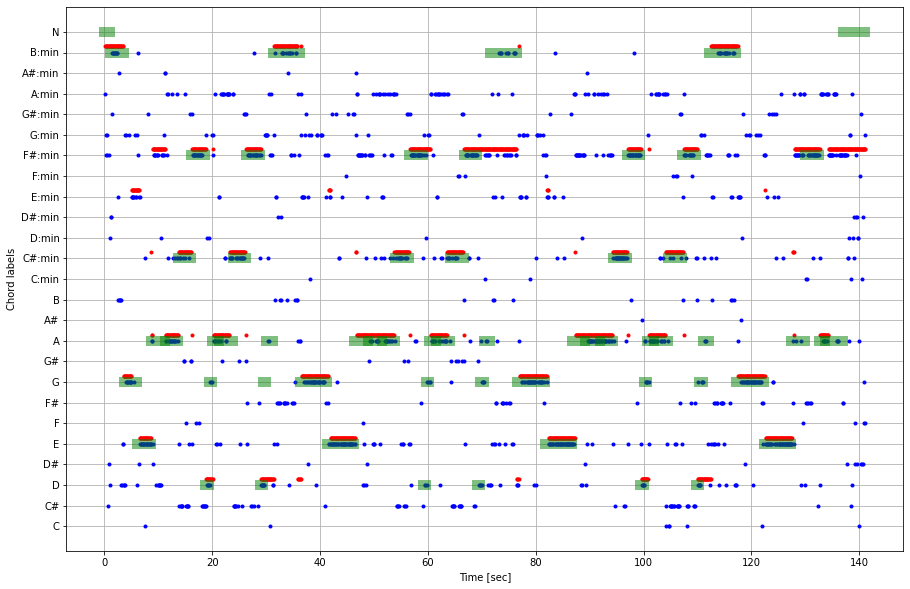

In [286]:
plt.figure(figsize=(15,10))
plt.plot(time_sec_v, argmax_path_v, 'b.')
plt.plot(time_sec_v, viterbi_path_v+0.3, 'r.')

groundtruth_v = np.zeros(len(time_sec_v))
for chord_annot in chord_annot_dl:
    start = chord_annot['time']
    end = chord_annot['time']+chord_annot['duration']
    value = chord_name_l.index( chord_annot['value'] )
    plt.plot( [start, end], [value, value], 'g-', linewidth=10, alpha=0.5 )
    
    pos_s = np.argmin(np.abs(start - time_sec_v))
    pos_e = np.argmin(np.abs(end - time_sec_v))
    groundtruth_v[pos_s:pos_e] = value
plt.xlabel('Time [sec]'); 
plt.ylabel('Chord labels'); 
plt.yticks(np.arange(0,nb_chord), chord_name_l);
plt.grid(True)

### Measuring the performances

We finally compare the performances obtained using our two systems (frame-based and HMM-based) using the Cord-Symbol-Recall: $CSR=\frac{\mbox{total duration of segments where annotation equal estimation}}{\mbox{total duration of annotated segments}}$.

Our **HMM-based** system get a score of 0.7836 which is quiet good for such a simple system. The **Frame-based** system only reach 0.4290.

In [287]:
frame_OCR = np.sum(groundtruth_v == argmax_path_v)/len(groundtruth_v)
hmm_OCR = np.sum(groundtruth_v == viterbi_path_v)/len(groundtruth_v)
print('Frame-based OCR', hmm_OCR)
print('HMM-based OCR', frame_OCR)

Frame-based OCR 0.7319148936170212
HMM-based OCR 0.4099290780141844
